# About

This research compares two different classification methodologies.
It will initially attempt to replicate the methodology used by FieldPlant research. This appears to be a multiclass classification methodology, as it uses a softmax activation function, which would select the most likely disease present in the image, but would fail to detect if moe than one disease was present.

The second methodology is to use a multilabel classification methodology, as this should be more appropriate for this dataset, as there are several images which contain more than 1 disease type.

# Import required libraries

In [70]:
import kagglehub
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Download Dataset

In [71]:
# Download latest version of data
# Use the next 2 lines if not downloaded before
image_dir = kagglehub.dataset_download("bloox2/fieldplant")
image_dir = Path(image_dir) / "train"

# Use the next lines of code if your data has been downloaded already, but you are offline.  Will used cached data.
# image_dir = "~/.cache/kagglehub/datasets/bloox2/fieldplant/versions/1/train"
# print("Path to dataset files:", image_dir)

Path to dataset files: /home/ruairi/.cache/kagglehub/datasets/bloox2/fieldplant/versions/1/train


## Data Inspection

### Dataframe

In [72]:
annotations_path = list((path / "train").glob("*.csv"))[0]

df = pd.read_csv(annotations_path)
df = df.rename(columns={"class":"disease"})

print(df.shape)
df.head(3)

(8580, 8)


,filename,width,height,disease,xmin,ymin,xmax,ymax
0,Manioc_Mosaique-839-_jpg.rf.40e7fcfcbd934d0e5e...,4160,2340,Cassava Mosaic,172,86,3255,2340
1,IMG20221216173252_jpg.rf.4122b742695fa3a71ba20...,3120,3120,Corn leaf blight,790,422,3120,3120
2,IMG_20221118_093039_956_jpg.rf.4122cbc73b4e7ab...,1920,2560,Tomato blight leaf,492,81,1755,1545


### Duplicates

In [73]:
# No duplicates across all columns.
df.duplicated().sum()

np.int64(0)

In [74]:
# Duplicated filenames due to an image filename being able to have >1 identified diseased leaf.
df[df.duplicated(subset="filename", keep=False)].head(5)

,filename,width,height,disease,xmin,ymin,xmax,ymax
3,Mais_Mildiou_-154-_jpg.rf.41330ed01bd1bc295999...,3120,3120,Corn leaf blight,64,752,1742,2771
4,Mais_Mildiou_-154-_jpg.rf.41330ed01bd1bc295999...,3120,3120,Corn leaf blight,2124,0,3120,3099
6,Tomate_Taches_Brunes-303-_jpg.rf.40ddb55bb5f0f...,3120,4160,Tomato Brown Spots,944,1512,2030,3874
7,Tomate_Taches_Brunes-303-_jpg.rf.40ddb55bb5f0f...,3120,4160,Tomato Brown Spots,0,514,1693,1302
8,Tomate_Taches_Brunes-303-_jpg.rf.40ddb55bb5f0f...,3120,4160,Tomato Brown Spots,1644,752,3045,1898


In [75]:
# Not interested in location of disease, just whether a disease is preset in the image
df = df.loc[:, ["filename", "disease"]]
df = df.drop_duplicates().sort_values(by="filename")
print(df.shape)
df.head(3)

(5346, 2)


,filename,disease
5066,Charbon_de_mais-1-_jpg.rf.d83e40544e3be2dac4fd...,Corn Smut
5468,Charbon_de_mais-2-_jpg.rf.e2c36854e8f83c0f5cdd...,Corn Smut
8267,Charbon_de_mais-3-_jpg.rf.7779b177d76937957b47...,Corn Smut


In [76]:
# No duplicate filename and disease
df.duplicated().sum()

np.int64(0)

In [77]:
# Duplicates of filename column means that each file may have more than 1 type of disease.  
df.duplicated(subset="filename").sum()

np.int64(190)

### Filenames
Ensure that the filenames in the images directory matches the filenames in the annotations data

In [78]:
image_dir = path / "train"

# Filenames in Images Directory
filenames_in_dir = sorted([f.name for f in image_dir.glob("*.jpg")])
print(filenames_in_dir[:3])
print()

# Filenames in directory match filenames in Dataframe
print("Filenames in image directory matches the filenames in the annotations.csv?:")
print(np.all(filenames_in_dir == df.filename.unique()))

['Charbon_de_mais-1-_jpg.rf.d83e40544e3be2dac4fd66077d50344a.jpg', 'Charbon_de_mais-2-_jpg.rf.e2c36854e8f83c0f5cdd4ba854405c87.jpg', 'Charbon_de_mais-3-_jpg.rf.7779b177d76937957b4740e3528ad485.jpg']

Filenames in image directory matches the filenames in the annotations.csv?:
True


## Value Counts

There are 2 classes of disease that both only have 1 sample each.  This is not suitable for splitting in a training / testing dataset. 
These samples will be dropped from the dataset.

In [79]:
df['crop'] = df.disease.apply(lambda x: x.split()[0])

In [80]:
df_disease = df.loc[:, ["filename", "disease"]]
print("Num duplicated rows for filename/disease: ", df_disease.duplicated().sum() )

df_crop = df.loc[:, ["filename", "crop"]]
print("Num duplicated rows for filename/crop: ", df_crop.duplicated().sum() )

Num duplicated rows for filename/disease:  0
Num duplicated rows for filename/crop:  189


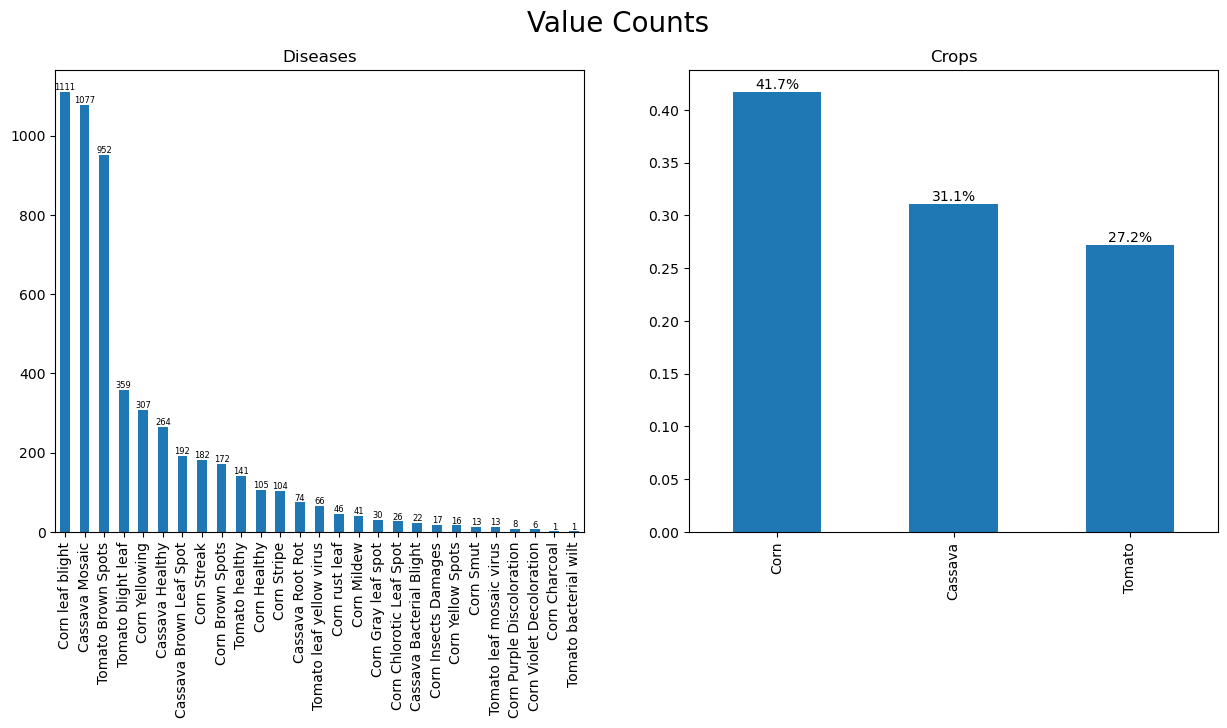

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle("Value Counts", fontsize=20)

df_disease.disease.value_counts().plot.bar(ax=ax1, title="Diseases");
ax1.bar_label(ax1.containers[0], fontsize=6);
ax1.set_xlabel("")

df_crop = df_crop.drop_duplicates()
ax2 = df_crop.crop.value_counts(normalize=True).plot.bar(title="Crops");
ax2.bar_label(ax2.containers[0],
              labels=[f'{(v*100):.1f}%' for v in df_crop.crop.value_counts(normalize=True).values])
ax2.set_xlabel("");

In [82]:
# Identify the 2 disease classes with only 1 sample each
diseases_to_drop = ["Corn Charcoal", "Tomato bacterial wilt"]
# Get the filenames of these samples
filenames_to_drop = df.loc[df.disease.isin(diseases_to_drop)].filename

# Check all records in filename column that match these filenames.
# Searching for the filename only returns 1 record each, meaning that this file only contains one type of disease and is not usable for any other disease class.
df[df.filename.isin(filenames_to_drop)]

,filename,disease,crop
4573,Charbon_de_mais-4-_jpg.rf.ca11615701c2f1d7dd45...,Corn Charcoal,Corn
1904,Tomate_Fletrissement-5-_jpg.rf.9b21131f2fa13e1...,Tomato bacterial wilt,Tomato


### Multilabel Classification

### Convert to Binary Encoding
As this is a multi-label classification task, Binary encoding will be used instead of One Hot Encoding.  Each row can have more than one disease column with a "1" present.

In [83]:
# Binary encode dataframe
df_b = pd.crosstab(df.filename, df.disease).reset_index()
df_b.columns.name = None

# Find the number of diseases per image, by summing across all the disease columns.
df_b['num_diseases'] = np.sum(df_b.iloc[:, 2:], axis=1)

print(df_b.shape)
df_b.head(3)

(5156, 29)


,filename,Cassava Bacterial Blight,Cassava Brown Leaf Spot,Cassava Healthy,Cassava Mosaic,Cassava Root Rot,Corn Brown Spots,Corn Charcoal,Corn Chlorotic Leaf Spot,Corn Gray leaf spot,...,Corn Yellowing,Corn leaf blight,Corn rust leaf,Tomato Brown Spots,Tomato bacterial wilt,Tomato blight leaf,Tomato healthy,Tomato leaf mosaic virus,Tomato leaf yellow virus,num_diseases
0,Charbon_de_mais-1-_jpg.rf.d83e40544e3be2dac4fd...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Charbon_de_mais-2-_jpg.rf.e2c36854e8f83c0f5cdd...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Charbon_de_mais-3-_jpg.rf.7779b177d76937957b47...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [84]:
# Check files to drop.
# Each file only contains 1 disease, so file is not usable for other disease classes. 
df_b[df_b.filename.isin(filenames_to_drop)]

,filename,Cassava Bacterial Blight,Cassava Brown Leaf Spot,Cassava Healthy,Cassava Mosaic,Cassava Root Rot,Corn Brown Spots,Corn Charcoal,Corn Chlorotic Leaf Spot,Corn Gray leaf spot,...,Corn Yellowing,Corn leaf blight,Corn rust leaf,Tomato Brown Spots,Tomato bacterial wilt,Tomato blight leaf,Tomato healthy,Tomato leaf mosaic virus,Tomato leaf yellow virus,num_diseases
3,Charbon_de_mais-4-_jpg.rf.ca11615701c2f1d7dd45...,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4177,Tomate_Fletrissement-5-_jpg.rf.9b21131f2fa13e1...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [85]:
# Check the unique values for the num_disease per image
df_b.num_diseases.unique()

array([1, 2, 3, 0])

In [86]:
# No duplicates in the filename column.  Now each row indicates an individual image.
df_b.duplicated(subset="filename").sum()

np.int64(0)

In [87]:
# An example of an image with 3 different diseases.
df_b[df_b.num_diseases == 3]

,filename,Cassava Bacterial Blight,Cassava Brown Leaf Spot,Cassava Healthy,Cassava Mosaic,Cassava Root Rot,Corn Brown Spots,Corn Charcoal,Corn Chlorotic Leaf Spot,Corn Gray leaf spot,...,Corn Yellowing,Corn leaf blight,Corn rust leaf,Tomato Brown Spots,Tomato bacterial wilt,Tomato blight leaf,Tomato healthy,Tomato leaf mosaic virus,Tomato leaf yellow virus,num_diseases
368,IMG_20221118_081835_744_jpg.rf.33cfed71f73ac3e...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,3


### Save Processed dataframes
The unfiltered version is saved also, as this is what is used in the originial FieldPlant research.  Their experiments will be replicated with this dataset.
The filtered version is saved to use in the main experiments of this research.  It has been filtered to allow for stratified split for multilabel classification methodology.

In [88]:
df_b = df_b.drop(columns=["num_diseases"])
df_b.head()

,filename,Cassava Bacterial Blight,Cassava Brown Leaf Spot,Cassava Healthy,Cassava Mosaic,Cassava Root Rot,Corn Brown Spots,Corn Charcoal,Corn Chlorotic Leaf Spot,Corn Gray leaf spot,...,Corn Yellow Spots,Corn Yellowing,Corn leaf blight,Corn rust leaf,Tomato Brown Spots,Tomato bacterial wilt,Tomato blight leaf,Tomato healthy,Tomato leaf mosaic virus,Tomato leaf yellow virus
0,Charbon_de_mais-1-_jpg.rf.d83e40544e3be2dac4fd...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Charbon_de_mais-2-_jpg.rf.e2c36854e8f83c0f5cdd...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Charbon_de_mais-3-_jpg.rf.7779b177d76937957b47...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Charbon_de_mais-4-_jpg.rf.ca11615701c2f1d7dd45...,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Charbon_de_mais-5-_jpg.rf.85b069615e2279858d49...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
# Save processed Dataframe to CSV
df_b.to_csv("../data/unfiltered.csv", index=False)

In [90]:
wide_filtered = df_b[~df_b.filename.isin(filenames_to_drop)]
wide_filtered = wide_filtered.loc[:, (wide_filtered != 0).any(axis=0)]
print(wide_filtered.shape)

(5154, 26)


In [91]:
wide_filtered.to_csv("../data/filtered.csv", index=False)

### Reload Processed CSV

In [92]:
# Reload processed Dataframe and inspect shape
df = pd.read_csv("../data/filtered.csv")

print(df.shape)
df.head(3)

(5154, 26)


,filename,Cassava Bacterial Blight,Cassava Brown Leaf Spot,Cassava Healthy,Cassava Mosaic,Cassava Root Rot,Corn Brown Spots,Corn Chlorotic Leaf Spot,Corn Gray leaf spot,Corn Healthy,...,Corn Violet Decoloration,Corn Yellow Spots,Corn Yellowing,Corn leaf blight,Corn rust leaf,Tomato Brown Spots,Tomato blight leaf,Tomato healthy,Tomato leaf mosaic virus,Tomato leaf yellow virus
0,Charbon_de_mais-1-_jpg.rf.d83e40544e3be2dac4fd...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Charbon_de_mais-2-_jpg.rf.e2c36854e8f83c0f5cdd...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Charbon_de_mais-3-_jpg.rf.7779b177d76937957b47...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
